In [1]:
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from matplotlib import pyplot

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [2]:
df = pd.read_csv("yelp_review_sentiment_2classes.tsv", delimiter="\t")
df = df.dropna()

## Experiments

In [3]:
en_stopwords = stopwords.words('english') + ["-PRON-", "-pron-", "PRON", "pron"]

cnt_vec = CountVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
label_enc = LabelEncoder()
label_bin = LabelBinarizer()
normalizer = Normalizer()
pca_cnt = TruncatedSVD(300)
pca_tfidf = TruncatedSVD(300)

In [4]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

cnt_vec.fit(train["text"])
tfidf_vec.fit(train["text"])
label_enc.fit(df["sentiment"].unique())

pca_cnt.fit(cnt_vec.transform(train["text"]))
pca_tfidf.fit(tfidf_vec.transform(train["text"]))

TruncatedSVD(n_components=300)

In [5]:
logistic = LogisticRegression(random_state=42, max_iter=100000)
mnb = MultinomialNB()


combinations = [
    (logistic, cnt_vec, None, None),
    (logistic, tfidf_vec, None, None),
    (logistic, cnt_vec, normalizer, None),
    (logistic, tfidf_vec, normalizer, None),
    (logistic, cnt_vec, None, pca_cnt),
    (logistic, tfidf_vec, None, pca_tfidf),
    (mnb, cnt_vec, None, None)
]

res2 = {}
for comb in combinations:
    model = comb[0]
    model_name = type(model).__name__
    
    print("Prepare data to train..")
    featurizer = comb[1]
    featurizer_name = type(featurizer).__name__
    X_train = featurizer.transform(train["text"])
    y_train = label_enc.transform(train["sentiment"])
    X_test = featurizer.transform(test["text"])
    y_test = label_enc.transform(test["sentiment"])
    
    normalizer_name = "None"
    if comb[2]:
        normalizer = comb[2]
        normalizer_name = type(normalizer).__name__
        X_train = normalizer.fit_transform(X_train)
        X_test = normalizer.transform(X_test)
        
    decomposer_name = "None"
    if comb[3]:
        decomposer = comb[3]
        decomposer = comb[3]
        decomposer_name = type(decomposer).__name__
        X_train = decomposer.transform(X_train)
        X_test = decomposer.transform(X_test)
        
    metadata = model_name + "-" + featurizer_name + "-" + normalizer_name + "-" + decomposer_name
    
    print("Cross-validate {}".format(metadata))
    score = cross_validate(model, X_train, y_train,
                           scoring=["f1_micro", "precision_micro", "recall_micro"],
                           cv=5, n_jobs=-1, return_train_score=True)
    res2[metadata] = score
    print(metadata, score)
    print()

Prepare data to train..
Cross-validate LogisticRegression-CountVectorizer-None-None
LogisticRegression-CountVectorizer-None-None {'fit_time': array([167.41764402, 166.77820396, 167.65471077, 170.0437572 ,
       161.73600793]), 'score_time': array([0.38634777, 0.42887092, 0.35161114, 0.17007279, 0.64798999]), 'test_f1_micro': array([0.9238599 , 0.92352654, 0.92443773, 0.92345986, 0.92494888]), 'train_f1_micro': array([0.99737754, 0.99739977, 0.99752756, 0.99733865, 0.99746089]), 'test_precision_micro': array([0.9238599 , 0.92352654, 0.92443773, 0.92345986, 0.92494888]), 'train_precision_micro': array([0.99737754, 0.99739977, 0.99752756, 0.99733865, 0.99746089]), 'test_recall_micro': array([0.9238599 , 0.92352654, 0.92443773, 0.92345986, 0.92494888]), 'train_recall_micro': array([0.99737754, 0.99739977, 0.99752756, 0.99733865, 0.99746089])}

Prepare data to train..
Cross-validate LogisticRegression-TfidfVectorizer-None-None
LogisticRegression-TfidfVectorizer-None-None {'fit_time': array

## Performance Calculation

In [6]:
analysis_df = pd.DataFrame()
for k, v in res2.items():
    tmp_df = pd.DataFrame.from_dict(res2[k])
    tmp_df["meta"] = k
    
    analysis_df = pd.concat([analysis_df, tmp_df])

(0.8, 0.95)

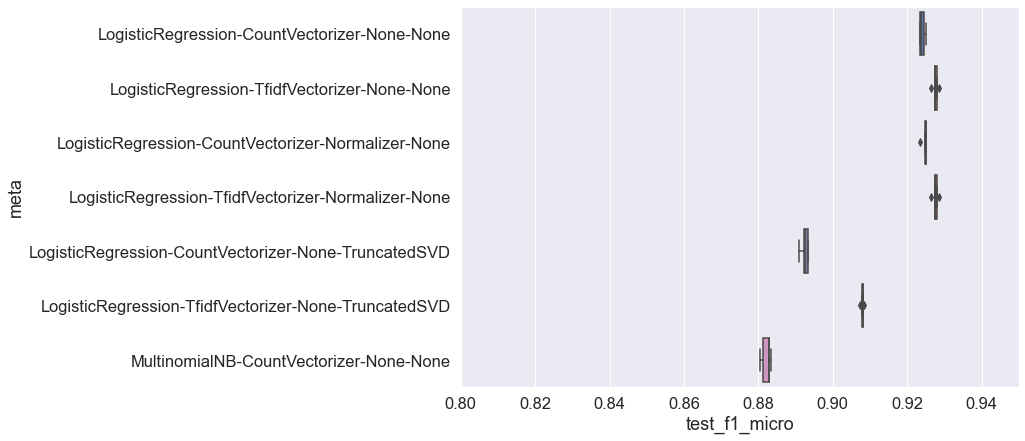

In [7]:
sns.set(font_scale=1.5)
a4_dims = (10, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.boxplot(data=analysis_df, x="test_f1_micro", y="meta")
g.set_xlim([0.8, 0.95])

In [8]:
analysis_df.to_csv("sklearn_performance.csv", index=False)